<div class="alert alert-block alert-success">

# **1.** **Setup**

<div>

In [1]:
from utils import *
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import GridSearchCV


In [2]:
# Set random seeds for reproducibility
tf.random.set_seed(221)
random.seed(221)
np.random.seed(221)
tf.random.set_seed(221)

## **1.1** Datasets

In [3]:
# Load the train/val split data
with open('train_val_split.pkl', 'rb') as f:
    data = pickle.load(f)

# Store the data in variables
x_train = data['x_train']
x_val = data['x_val']
y_train = data['y_train']
y_val = data['y_val']

In [4]:
# For EXTRA

# Load the train/val split data without preprocessing
with open('train_val_split_no_preproc.pkl', 'rb') as f:
    data_no_preproc = pickle.load(f)

# Convert DataFrames to list
train_texts = data_no_preproc['x_train'].tolist()
val_texts = data_no_preproc['x_val'].tolist()

# Convert Series to list
train_labels = data_no_preproc['y_train'].tolist()
val_labels = data_no_preproc['y_val'].tolist()



In [5]:
from collections import defaultdict
from sklearn.utils import resample
import random
import nlpaug.augmenter.word as naw
from collections import Counter

def oversample_data(texts, labels, max_oversample=3000, apply_eda=True, eda_for_minority_only=True):
    label_to_texts = defaultdict(list)
    for text, label in zip(texts, labels):
        label_to_texts[label].append(text)

    label_counts = {label: len(texts) for label, texts in label_to_texts.items()}
    max_len = min(max(label_counts.values()), max_oversample)

    oversampled_texts, oversampled_labels = [], []

    if apply_eda:
        aug = naw.SynonymAug(aug_src='wordnet', aug_p=0.3)

    for label, class_texts in label_to_texts.items():
        resampled = []
        for i in range(max_len):
            t = random.choice(class_texts)
            # Só aplica EDA se:
            # - estamos além da quantidade original
            # - e apply_eda está ativo
            # - e (ou EDA é para todos ou esta é uma classe minoritária)
            if (
                i >= len(class_texts)
                and apply_eda
                and (not eda_for_minority_only or len(class_texts) < max_len)
            ):
                try:
                    t = aug.augment(t)
                except:
                    pass
            resampled.append(t)

        oversampled_texts.extend(resampled)
        oversampled_labels.extend([label] * max_len)

    return oversampled_texts, oversampled_labels



In [6]:
balanced_texts, balanced_labels = oversample_data(
    texts=train_texts,
    labels=train_labels,
    max_oversample=3000,
    apply_eda=True,
    eda_for_minority_only=True
)


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/margaridabravocardoso/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/margaridabravocardoso/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/margaridabravocardoso/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/margaridabravocardoso/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/margaridabravocardoso/nltk_data...
[nltk_data]   Package averaged_perce

In [7]:
from collections import Counter
print(Counter(balanced_labels))


Counter({2: 3000, 1: 3000, 0: 3000})


In [8]:
len(balanced_texts)

9000

## **1.2** Parameters

In [9]:
# ------- Parameters ------- 
# Glove
emb_size = 200 # start small than increase to find the best value

# TF-IDF
max_df = 0.8 # we are removing terms that appear in >80% of tweets

# Word2Vec
window = 2         # context window size
min_count = 1      # minimum word frequency to include

## **1.3** General

In [10]:
corpus = x_train['text']

#get list with lenghts of sentences
train_len = []
for i in corpus:
    train_len.append(len(i))

vector_size = max(train_len)

metrics_df = []

In [11]:
tokenized_train = [word_tokenize(tweet.lower()) for tweet in x_train['text']]
max_seq_len = max(len(tokens) for tokens in tokenized_train)

## **1.4** Models

### Glove

In [12]:
model_name = 'glove-twitter'
glove_model = gensim.downloader.load(f'{model_name}-{emb_size}')

### Text Embeddings 3 Small

In [13]:
# EXTRA

# Load variables from .env into environment
load_dotenv()

# Print environment variable
print("AZURE_OPENAI_ENDPOINT:", os.getenv("AZURE_OPENAI_ENDPOINT"))

# Initialize Azure OpenAI client
client = AzureOpenAI(
    api_key=os.getenv("AZURE_OPENAI_KEY"),
    api_version="2024-02-01",
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT")
)

# Define embedding model
model = "text-embedding-3-small"

AZURE_OPENAI_ENDPOINT: https://novaimsplayground.openai.azure.com/


In [14]:
# Define embedding model text embedding
model_te3s = "text-embedding-3-small"

### Roberta

In [15]:
# Load the pre-trained model and tokenizer for roberta
model_name = "cardiffnlp/twitter-roberta-base"
tokenizer_roberta = AutoTokenizer.from_pretrained(model_name)
model_roberta = AutoModel.from_pretrained(model_name)

### LSTM

In [16]:
input_ = Input(shape=(max_seq_len, vector_size))

x = Masking(mask_value=0.0)(input_)
x = Bidirectional(LSTM(units=units, return_sequences=False, dropout=dropout, recurrent_dropout=dropout))(x)
x = Dropout(dropout)(x)
output = Dense(num_class, activation='softmax')(x)

NameError: name 'units' is not defined

<div class="alert alert-block alert-success">

# **2.** **Hyperparameter Tuning**

<div>

## **2.1** LR with Text Embedding 3

### **2.1.1** Running Model

In [65]:
model = LogisticRegression(max_iter=1000)

In [ ]:
X_train_te3s, X_val_te3s, y_train_pred_te3s, y_val_pred_te3s = embedding_te3s(
    train_texts=train_texts,
    train_labels=train_labels,
    val_texts=val_texts, 
    cache_file_train="X_train_te3s_embeddings.pkl", 
    cache_file_val="X_val_te3s_embeddings.pkl",
    client=client,
    model_te3s=model_te3s,
    batch_size=32,
    model=model
)


Loading embeddings from X_train_te3s_embeddings.pkl...
Loading embeddings from X_val_te3s_embeddings.pkl...


In [15]:
X_combined = np.vstack([X_train_te3s, X_val_te3s])
y_combined = np.concatenate([train_labels, val_labels])

split_index = [-1]*len(X_train_te3s) + [0]*len(X_val_te3s)
ps = PredefinedSplit(test_fold=split_index)

In [ ]:
param_grid = [
    {'penalty': ['l1'], 'solver': ['saga'], 'C': [0.01, 0.1, 1, 10],
     'class_weight': [None, 'balanced'], 'multi_class': ['ovr', 'multinomial']},

    {'penalty': ['l2'], 'solver': ['saga'], 'C': [0.01, 0.1, 1, 10],
     'class_weight': [None, 'balanced'], 'multi_class': ['ovr', 'multinomial']},

    {'penalty': ['elasticnet'], 'solver': ['saga'], 'C': [0.01, 0.1, 1, 10],
     'l1_ratio': [0.0, 0.5, 1.0], 'class_weight': [None, 'balanced'], 'multi_class': ['ovr', 'multinomial']}
]

grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='f1_macro',  
    cv=ps,
    verbose=2,
    n_jobs=-1,
    error_score='raise'
)

grid.fit(X_combined, y_combined)

Fitting 1 folds for each of 80 candidates, totalling 80 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' wa

[CV] END C=0.01, class_weight=None, multi_class=multinomial, penalty=l1, solver=saga; total time=   1.5s
[CV] END C=0.01, class_weight=None, multi_class=ovr, penalty=l1, solver=saga; total time=   1.6s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=0.01, class_weight=balanced, multi_class=ovr, penalty=l1, solver=saga; total time=   2.0s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=0.01, class_weight=balanced, multi_class=multinomial, penalty=l1, solver=saga; total time=   2.4s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=0.1, class_weight=None, multi_class=ovr, penalty=l1, solver=saga; total time=   6.2s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=0.1, class_weight=balanced, multi_class=ovr, penalty=l1, solver=saga; total time=   6.3s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=0.1, class_weight=balanced, multi_class=multinomial, penalty=l1, solver=saga; total time=   6.4s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=0.1, class_weight=None, multi_class=multinomial, penalty=l1, solver=saga; total time=   8.8s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=1, class_weight=balanced, multi_class=ovr, penalty=l1, solver=saga; total time=  26.3s
[CV] END C=1, class_weight=None, multi_class=ovr, penalty=l1, solver=saga; total time=  27.0s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=1, class_weight=None, multi_class=multinomial, penalty=l1, solver=saga; total time=  29.3s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=1, class_weight=balanced, multi_class=multinomial, penalty=l1, solver=saga; total time=  29.5s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=0.01, class_weight=None, multi_class=ovr, penalty=l2, solver=saga; total time=   4.3s
[CV] END C=0.01, class_weight=None, multi_class=multinomial, penalty=l2, solver=saga; total time=   4.3s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=0.01, class_weight=balanced, multi_class=ovr, penalty=l2, solver=saga; total time=   5.6s
[CV] END C=0.1, class_weight=None, multi_class=multinomial, penalty=l2, solver=saga; total time=   3.8s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=0.1, class_weight=None, multi_class=ovr, penalty=l2, solver=saga; total time=   4.1s
[CV] END C=0.01, class_weight=balanced, multi_class=multinomial, penalty=l2, solver=saga; total time=   5.0s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=1, class_weight=None, multi_class=multinomial, penalty=l2, solver=saga; total time=   4.3s
[CV] END C=1, class_weight=None, multi_class=ovr, penalty=l2, solver=saga; total time=   4.4s
[CV] END C=0.1, class_weight=balanced, multi_class=multinomial, penalty=l2, solver=saga; total time=   4.6s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=0.1, class_weight=balanced, multi_class=ovr, penalty=l2, solver=saga; total time=   5.0s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=1, class_weight=balanced, multi_class=ovr, penalty=l2, solver=saga; total time=   5.3s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=1, class_weight=balanced, multi_class=multinomial, penalty=l2, solver=saga; total time=   6.1s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=10, class_weight=None, multi_class=multinomial, penalty=l2, solver=saga; total time=  11.6s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=10, class_weight=None, multi_class=ovr, penalty=l2, solver=saga; total time=  15.3s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=0.01, class_weight=None, l1_ratio=0.0, multi_class=ovr, penalty=elasticnet, solver=saga; total time=   4.8s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=0.01, class_weight=None, l1_ratio=0.5, multi_class=ovr, penalty=elasticnet, solver=saga; total time=   1.5s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=0.01, class_weight=None, l1_ratio=0.0, multi_class=multinomial, penalty=elasticnet, solver=saga; total time=   4.6s
[CV] END C=0.01, class_weight=None, l1_ratio=0.5, multi_class=multinomial, penalty=elasticnet, solver=saga; total time=   1.7s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=10, class_weight=balanced, multi_class=ovr, penalty=l2, solver=saga; total time=  15.7s
[CV] END C=0.01, class_weight=None, l1_ratio=1.0, multi_class=multinomial, penalty=elasticnet, solver=saga; total time=   1.1s
[CV] END C=0.01, class_weight=None, l1_ratio=1.0, multi_class=ovr, penalty=elasticnet, solver=saga; total time=   1.1s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=0.01, class_weight=balanced, l1_ratio=0.5, multi_class=ovr, penalty=elasticnet, solver=saga; total time=   3.4s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=0.01, class_weight=balanced, l1_ratio=0.0, multi_class=multinomial, penalty=elasticnet, solver=saga; total time=   6.0s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=0.01, class_weight=balanced, l1_ratio=0.0, multi_class=ovr, penalty=elasticnet, solver=saga; total time=   7.6s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=0.01, class_weight=balanced, l1_ratio=0.5, multi_class=multinomial, penalty=elasticnet, solver=saga; total time=   4.8s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=0.01, class_weight=balanced, l1_ratio=1.0, multi_class=ovr, penalty=elasticnet, solver=saga; total time=   2.8s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=0.01, class_weight=balanced, l1_ratio=1.0, multi_class=multinomial, penalty=elasticnet, solver=saga; total time=   2.3s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=0.1, class_weight=None, l1_ratio=0.0, multi_class=multinomial, penalty=elasticnet, solver=saga; total time=   4.8s
[CV] END C=0.1, class_weight=None, l1_ratio=0.0, multi_class=ovr, penalty=elasticnet, solver=saga; total time=   5.4s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=0.1, class_weight=None, l1_ratio=0.5, multi_class=ovr, penalty=elasticnet, solver=saga; total time=   7.6s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=0.1, class_weight=None, l1_ratio=0.5, multi_class=multinomial, penalty=elasticnet, solver=saga; total time=   7.2s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=0.1, class_weight=None, l1_ratio=1.0, multi_class=ovr, penalty=elasticnet, solver=saga; total time=   7.8s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=0.1, class_weight=None, l1_ratio=1.0, multi_class=multinomial, penalty=elasticnet, solver=saga; total time=   9.2s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=0.1, class_weight=balanced, l1_ratio=0.0, multi_class=ovr, penalty=elasticnet, solver=saga; total time=   6.4s
[CV] END C=0.1, class_weight=balanced, l1_ratio=0.0, multi_class=multinomial, penalty=elasticnet, solver=saga; total time=   5.8s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=0.1, class_weight=balanced, l1_ratio=1.0, multi_class=ovr, penalty=elasticnet, solver=saga; total time=   7.1s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=0.1, class_weight=balanced, l1_ratio=0.5, multi_class=multinomial, penalty=elasticnet, solver=saga; total time=   7.8s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=0.1, class_weight=balanced, l1_ratio=0.5, multi_class=ovr, penalty=elasticnet, solver=saga; total time=   8.7s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=1, class_weight=None, l1_ratio=0.0, multi_class=multinomial, penalty=elasticnet, solver=saga; total time=   5.3s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=1, class_weight=None, l1_ratio=0.0, multi_class=ovr, penalty=elasticnet, solver=saga; total time=   6.2s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=0.1, class_weight=balanced, l1_ratio=1.0, multi_class=multinomial, penalty=elasticnet, solver=saga; total time=   9.6s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=1, class_weight=None, l1_ratio=0.5, multi_class=multinomial, penalty=elasticnet, solver=saga; total time=   9.0s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=1, class_weight=None, l1_ratio=0.5, multi_class=ovr, penalty=elasticnet, solver=saga; total time=  10.1s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=10, class_weight=balanced, multi_class=multinomial, penalty=l2, solver=saga; total time= 1.1min


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=1, class_weight=balanced, l1_ratio=0.0, multi_class=ovr, penalty=elasticnet, solver=saga; total time=   6.3s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=1, class_weight=balanced, l1_ratio=0.0, multi_class=multinomial, penalty=elasticnet, solver=saga; total time=   7.3s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=1, class_weight=balanced, l1_ratio=0.5, multi_class=ovr, penalty=elasticnet, solver=saga; total time=  11.0s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=1, class_weight=balanced, l1_ratio=0.5, multi_class=multinomial, penalty=elasticnet, solver=saga; total time=  10.2s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=1, class_weight=None, l1_ratio=1.0, multi_class=ovr, penalty=elasticnet, solver=saga; total time=  30.0s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=1, class_weight=None, l1_ratio=1.0, multi_class=multinomial, penalty=elasticnet, solver=saga; total time=  33.9s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=10, class_weight=None, l1_ratio=0.0, multi_class=ovr, penalty=elasticnet, solver=saga; total time=  16.5s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=10, class_weight=None, l1_ratio=0.0, multi_class=multinomial, penalty=elasticnet, solver=saga; total time=  12.4s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=1, class_weight=balanced, l1_ratio=1.0, multi_class=ovr, penalty=elasticnet, solver=saga; total time=  30.1s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=1, class_weight=balanced, l1_ratio=1.0, multi_class=multinomial, penalty=elasticnet, solver=saga; total time=  35.5s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=10, class_weight=None, l1_ratio=0.5, multi_class=ovr, penalty=elasticnet, solver=saga; total time=  47.3s
[CV] END C=10, class_weight=None, l1_ratio=0.5, multi_class=multinomial, penalty=elasticnet, solver=saga; total time=  41.3s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=10, class_weight=balanced, l1_ratio=0.0, multi_class=ovr, penalty=elasticnet, solver=saga; total time=  17.9s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=10, class_weight=None, multi_class=multinomial, penalty=l1, solver=saga; total time= 3.9min


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=10, class_weight=balanced, l1_ratio=0.0, multi_class=multinomial, penalty=elasticnet, solver=saga; total time=  56.4s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=10, class_weight=None, multi_class=ovr, penalty=l1, solver=saga; total time= 4.2min


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=10, class_weight=balanced, l1_ratio=0.5, multi_class=ovr, penalty=elasticnet, solver=saga; total time=  44.8s
[CV] END C=10, class_weight=balanced, multi_class=ovr, penalty=l1, solver=saga; total time= 4.4min
[CV] END C=10, class_weight=balanced, multi_class=multinomial, penalty=l1, solver=saga; total time= 4.5min
[CV] END C=10, class_weight=None, l1_ratio=1.0, multi_class=ovr, penalty=elasticnet, solver=saga; total time= 4.0min
[CV] END C=10, class_weight=None, l1_ratio=1.0, multi_class=multinomial, penalty=elasticnet, solver=saga; total time= 3.9min
[CV] END C=10, class_weight=balanced, l1_ratio=1.0, multi_class=ovr, penalty=elasticnet, solver=saga; total time= 3.6min
[CV] END C=10, class_weight=balanced, l1_ratio=1.0, multi_class=multinomial, penalty=elasticnet, solver=saga; total time= 3.7min


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END C=10, class_weight=balanced, l1_ratio=0.5, multi_class=multinomial, penalty=elasticnet, solver=saga; total time= 5.0min


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             error_score='raise', estimator=LogisticRegression(max_iter=1000),
             n_jobs=-1,
             param_grid=[{'C': [0.01, 0.1, 1, 10],
                          'class_weight': [None, 'balanced'],
                          'multi_class': ['ovr', 'multinomial'],
                          'penalty': ['l1'], 'solver': ['saga']},
                         {'C': [0.01, 0.1, 1, 10],
                          'class_weight': [None, 'balanced'],
                          'multi_class': ['ovr', 'multinomial'],
                          'penalty': ['l2'], 'solver': ['saga']},
                         {'C': [0.01, 0.1, 1, 10],
                          'class_weight': [None, 'balanced'],
                          'l1_ratio': [0.0, 0.5, 1.0],
                          'multi_class': ['ovr', 'multinomial'],
                          'penalty': ['elasticnet'], 'solver': ['saga']}],
             scoring='f1_macro', verbose=2)

In [17]:
grid.best_params_      
grid.best_score_     
grid.best_estimator_

LogisticRegression(C=10, l1_ratio=0.5, max_iter=1000, multi_class='ovr',
                   penalty='elasticnet', solver='saga')

In [18]:
print(grid.best_params_)

{'C': 10, 'class_weight': None, 'l1_ratio': 0.5, 'multi_class': 'ovr', 'penalty': 'elasticnet', 'solver': 'saga'}


In [19]:
print(grid.best_score_)

0.8286196010737599


### **2.1.2** Assess

In [17]:
model_lr = LogisticRegression( penalty='elasticnet', 
    solver='saga', 
    l1_ratio=0.4, 
    C=10, 
    class_weight=None, 
    max_iter=1000, 
    multi_class='ovr')

In [18]:
title = "Logistic Regression with Text Embedding 3 Small"

In [20]:
X_train_te3s,X_val_te3s,y_train_pred_te3s,y_val_pred_te3s = embedding_te3s(train_texts=balanced_texts,
                                                                 train_labels=balanced_labels,
                                                                 val_texts = val_texts, 
                                                                 cache_file_train='te3s_train_augmented.pkl', 
                                                                 cache_file_val='te3s_val.pkl',
                                                                 client=client,
                                                                 model_te3s=model_te3s,
                                                                 batch_size=32,
                                                                 model=model_lr)

Generating embeddings in batches and saving to te3s_train_augmented.pkl...


100%|██████████| 282/282 [53:19<00:00, 11.35s/it]  


Generating embeddings in batches and saving to te3s_val.pkl...


100%|██████████| 60/60 [12:09<00:00, 12.16s/it]
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


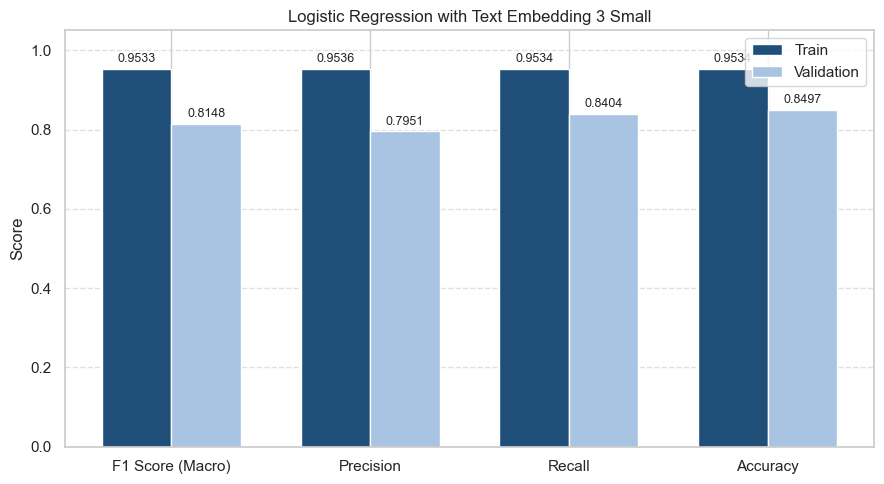

In [22]:
get_metrics_df(title, balanced_labels, y_train_pred_te3s, val_labels, y_val_pred_te3s)
plot_metrics(balanced_labels, y_train_pred_te3s, val_labels, y_val_pred_te3s, title=title)

## **2.2** XGB with Text Embedding 3

### **2.2.1** Run Model

In [20]:
xgb = XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

In [26]:
param_grid_xgb = {
    'learning_rate': [0.2, 0.1],
    'max_depth': [4, 6, 8],
    'n_estimators': [100, 500],
    'subsample': [0.7,1.0],
    'colsample_bytree': [0.8, 1.0],
    'scale_pos_weight': [1],  
}

In [23]:
X_train_te3s, X_val_te3s, y_train_pred_te3s, y_val_pred_te3s = embedding_te3s(
    train_texts=train_texts,
    train_labels=train_labels,
    val_texts=val_texts, 
    cache_file_train='te3s_train_augmented.pkl', 
    cache_file_val='te3s_val.pkl',
    client=client,
    model_te3s=model_te3s,
    batch_size=32,
    model=xgb
)


NameError: name 'xgb' is not defined

In [28]:
X_combined = np.vstack([X_train_te3s, X_val_te3s])
y_combined = np.concatenate([train_labels, val_labels])

split_index = [-1]*len(X_train_te3s) + [0]*len(X_val_te3s)
ps = PredefinedSplit(test_fold=split_index)

In [29]:
grid_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid_xgb,
    scoring='f1_macro',
    cv=ps,
    verbose=1,
    n_jobs=-1,
    error_score='raise'
)

In [30]:
grid_xgb.fit(X_combined, y_combined)

Fitting 1 folds for each of 48 candidates, totalling 48 fits


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:20:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:20:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:20:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:20:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not us

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             error_score='raise',
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='mlogloss', feature_types=None,
                                     gamma=None, grow_policy=...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_class=3,
                                     num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.2, 0.1], 'max_depth': [4, 6, 8],
                         'n_estimators': [100, 500], 'scale_pos_weight': [1],
                         'subsample': [0.7, 1.0]},
             scoring='f1_macro', verbose=1)

### **2.2.2** Assess

In [70]:
print(grid_xgb.best_params_)
print(grid_xgb.best_score_)

{'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 500, 'scale_pos_weight': 1, 'subsample': 0.7}
0.8159031481935677


In [24]:
xgb = XGBClassifier(
    colsample_bytree= 0.8, 
    learning_rate = 0.2,
    max_depth = 4,
    n_estimators = 500, scale_pos_weight= 1, subsample = 0.7,
    num_class=3,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

In [25]:
title = "XGB with Text Embedding 3 Small"

In [27]:
X_train_te3s,X_val_te3s,y_train_pred_te3s,y_val_pred_te3s = embedding_te3s(train_texts=balanced_texts,
                                                                 train_labels=balanced_labels,
                                                                 val_texts = val_texts, 
                                                                 cache_file_train='te3s_train_augmented.pkl', 
                                                                 cache_file_val='te3s_val.pkl',
                                                                 client=client,
                                                                 model_te3s=model_te3s,
                                                                 batch_size=32,
                                                                 model=xgb)

Loading embeddings from te3s_train_augmented.pkl...
Loading embeddings from te3s_val.pkl...


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:38:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


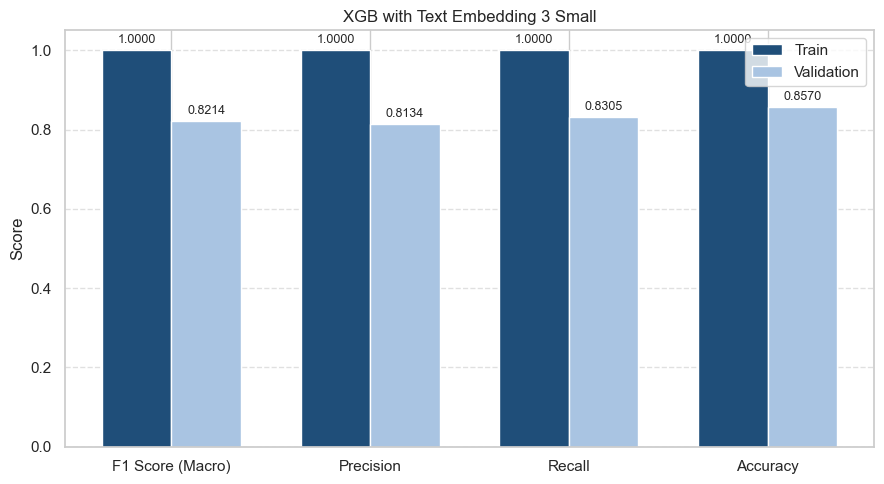

In [28]:
get_metrics_df(title, balanced_labels, y_train_pred_te3s, val_labels, y_val_pred_te3s)
plot_metrics(balanced_labels, y_train_pred_te3s, val_labels, y_val_pred_te3s, title=title)

## **2.3** LSTM with Glove

### **2.3.1** Running model

In [144]:
from sklearn.metrics import f1_score
import numpy as np


units_list = [64, 128]
dropout_list = [0.3, 0.4]
lr_list = [0.005, 0.001]

best_f1 = 0
best_params = {}

for units in units_list:
    for dropout in dropout_list:
        for lr in lr_list:
            print(f"\n Testing units={units}, dropout={dropout}, lr={lr}")

            input_ = Input(shape=(26, 200))
            x = Masking(mask_value=0.0)(input_)
            x = Bidirectional(LSTM(units=units, return_sequences=False, dropout=dropout, recurrent_dropout=dropout))(x)
            x = Dropout(dropout)(x)
            output = Dense(3, activation='softmax')(x)
            optimizer = Adam(learning_rate=lr)
            model_lstm = Model(inputs=input_, outputs=output)
            model_lstm.compile(optimizer=optimizer, loss='categorical_crossentropy',
                               metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

            # Train and evaluate
            _, _, y_val_pred = embedding_glove_lstm(
                x_train=x_train,
                y_train=y_train,
                x_val=x_val,
                y_val=y_val,
                model_glove=glove_model,
                emb_size=200,
                model_lstm=model_lstm,
                n_classes=3,
                batch_size=32,
                epochs=15
            )

            f1 = f1_score(y_val, y_val_pred, average='macro')
            print(f" Val F1 Score: {f1:.4f}")

            if f1 > best_f1:
                best_f1 = f1
                best_params = {'units': units, 'dropout': dropout, 'learning_rate': lr}

print("\nBest Params:", best_params)
print(f"Best Val F1: {best_f1:.4f}")



 Testing units=64, dropout=0.3, lr=0.005


100%|██████████| 1909/1909 [00:00<00:00, 20584.47it/s]


Epoch 1/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.6852 - loss: 0.7716 - precision_10: 0.7369 - recall_10: 0.5860 - val_accuracy: 0.7669 - val_loss: 0.5809 - val_precision_10: 0.8074 - val_recall_10: 0.7224
Epoch 2/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.7748 - loss: 0.5619 - precision_10: 0.8125 - recall_10: 0.7268 - val_accuracy: 0.7957 - val_loss: 0.5419 - val_precision_10: 0.8182 - val_recall_10: 0.7664
Epoch 3/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.8067 - loss: 0.4816 - precision_10: 0.8402 - recall_10: 0.7720 - val_accuracy: 0.8057 - val_loss: 0.5293 - val_precision_10: 0.8247 - val_recall_10: 0.7837
Epoch 4/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.8314 - loss: 0.4230 - precision_10: 0.8566 - recall_10: 0.8043 - val_accuracy: 0.8093 - val_loss: 0.5238 - val_precision_10: 0.8239 - val_recall_10: 0.7894
Epoch 5/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.8561 - loss: 0.3644 - precision_10: 0.87

100%|██████████| 1909/1909 [00:00<00:00, 21506.48it/s]


Epoch 1/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.6636 - loss: 0.8253 - precision_11: 0.7205 - recall_11: 0.5386 - val_accuracy: 0.7412 - val_loss: 0.6503 - val_precision_11: 0.7874 - val_recall_11: 0.6810
Epoch 2/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.7394 - loss: 0.6438 - precision_11: 0.7891 - recall_11: 0.6714 - val_accuracy: 0.7716 - val_loss: 0.5951 - val_precision_11: 0.8061 - val_recall_11: 0.7208
Epoch 3/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.7594 - loss: 0.5977 - precision_11: 0.8084 - recall_11: 0.6998 - val_accuracy: 0.7800 - val_loss: 0.5652 - val_precision_11: 0.8085 - val_recall_11: 0.7475
Epoch 4/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.7780 - loss: 0.5437 - precision_11: 0.8140 - recall_11: 0.7325 - val_accuracy: 0.7931 - val_loss: 0.5441 - val_precision_11: 0.8163 - val_recall_11: 0.7564
Epoch 5/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.8009 - loss: 0.5117 - precision_11: 0.834

100%|██████████| 1909/1909 [00:00<00:00, 21239.66it/s]


Epoch 1/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.6653 - loss: 0.8075 - precision_12: 0.7198 - recall_12: 0.5656 - val_accuracy: 0.7674 - val_loss: 0.5973 - val_precision_12: 0.8103 - val_recall_12: 0.7072
Epoch 2/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.7530 - loss: 0.6182 - precision_12: 0.7991 - recall_12: 0.6929 - val_accuracy: 0.7826 - val_loss: 0.5447 - val_precision_12: 0.8179 - val_recall_12: 0.7459
Epoch 3/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.7891 - loss: 0.5463 - precision_12: 0.8195 - recall_12: 0.7458 - val_accuracy: 0.8078 - val_loss: 0.5118 - val_precision_12: 0.8309 - val_recall_12: 0.7748
Epoch 4/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.8069 - loss: 0.4906 - precision_12: 0.8358 - recall_12: 0.7719 - val_accuracy: 0.8193 - val_loss: 0.5019 - val_precision_12: 0.8366 - val_recall_12: 0.7968
Epoch 5/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.8096 - loss: 0.4593 - precision_12: 0.840

100%|██████████| 1909/1909 [00:00<00:00, 22338.45it/s]


Epoch 1/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.6330 - loss: 0.8639 - precision_13: 0.6964 - recall_13: 0.5171 - val_accuracy: 0.7349 - val_loss: 0.6673 - val_precision_13: 0.7905 - val_recall_13: 0.6543
Epoch 2/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.7147 - loss: 0.6903 - precision_13: 0.7766 - recall_13: 0.6269 - val_accuracy: 0.7554 - val_loss: 0.6204 - val_precision_13: 0.7959 - val_recall_13: 0.6988
Epoch 3/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.7412 - loss: 0.6404 - precision_13: 0.7888 - recall_13: 0.6773 - val_accuracy: 0.7737 - val_loss: 0.5808 - val_precision_13: 0.8170 - val_recall_13: 0.7271
Epoch 4/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.7575 - loss: 0.5948 - precision_13: 0.8069 - recall_13: 0.7027 - val_accuracy: 0.7852 - val_loss: 0.5585 - val_precision_13: 0.8201 - val_recall_13: 0.7475
Epoch 5/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.7732 - loss: 0.5582 - precision_13: 0.813

100%|██████████| 1909/1909 [00:00<00:00, 22049.93it/s]


Epoch 1/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 18s 60ms/step - accuracy: 0.6835 - loss: 0.7778 - precision_14: 0.7419 - recall_14: 0.5871 - val_accuracy: 0.7784 - val_loss: 0.5688 - val_precision_14: 0.8212 - val_recall_14: 0.7339
Epoch 2/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 16s 66ms/step - accuracy: 0.7781 - loss: 0.5479 - precision_14: 0.8148 - recall_14: 0.7316 - val_accuracy: 0.8025 - val_loss: 0.5285 - val_precision_14: 0.8241 - val_recall_14: 0.7632
Epoch 3/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 16s 67ms/step - accuracy: 0.8199 - loss: 0.4620 - precision_14: 0.8472 - recall_14: 0.7805 - val_accuracy: 0.7988 - val_loss: 0.5506 - val_precision_14: 0.8166 - val_recall_14: 0.7816
Epoch 4/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 16s 66ms/step - accuracy: 0.8545 - loss: 0.3784 - precision_14: 0.8726 - recall_14: 0.8297 - val_accuracy: 0.8046 - val_loss: 0.5588 - val_precision_14: 0.8184 - val_recall_14: 0.7884
Epoch 5/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 15s 65ms/step - accuracy: 0.8713 - loss: 0.3221 - precision_14: 

100%|██████████| 1909/1909 [00:00<00:00, 21402.03it/s]


Epoch 1/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 17s 63ms/step - accuracy: 0.6762 - loss: 0.7993 - precision_15: 0.7285 - recall_15: 0.5626 - val_accuracy: 0.7496 - val_loss: 0.6312 - val_precision_15: 0.7901 - val_recall_15: 0.6941
Epoch 2/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 16s 69ms/step - accuracy: 0.7424 - loss: 0.6336 - precision_15: 0.7952 - recall_15: 0.6747 - val_accuracy: 0.7742 - val_loss: 0.5805 - val_precision_15: 0.8087 - val_recall_15: 0.7307
Epoch 3/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 17s 70ms/step - accuracy: 0.7747 - loss: 0.5715 - precision_15: 0.8134 - recall_15: 0.7255 - val_accuracy: 0.7884 - val_loss: 0.5517 - val_precision_15: 0.8137 - val_recall_15: 0.7507
Epoch 4/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 17s 70ms/step - accuracy: 0.7960 - loss: 0.5175 - precision_15: 0.8256 - recall_15: 0.7562 - val_accuracy: 0.8020 - val_loss: 0.5340 - val_precision_15: 0.8275 - val_recall_15: 0.7590
Epoch 5/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 17s 70ms/step - accuracy: 0.8109 - loss: 0.4718 - precision_15: 

100%|██████████| 1909/1909 [00:00<00:00, 21271.14it/s]


Epoch 1/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 18s 65ms/step - accuracy: 0.6729 - loss: 0.7918 - precision_16: 0.7320 - recall_16: 0.5814 - val_accuracy: 0.7648 - val_loss: 0.5986 - val_precision_16: 0.8015 - val_recall_16: 0.7192
Epoch 2/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 17s 72ms/step - accuracy: 0.7634 - loss: 0.5990 - precision_16: 0.8018 - recall_16: 0.7065 - val_accuracy: 0.7915 - val_loss: 0.5476 - val_precision_16: 0.8182 - val_recall_16: 0.7522
Epoch 3/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 17s 72ms/step - accuracy: 0.7941 - loss: 0.5240 - precision_16: 0.8249 - recall_16: 0.7561 - val_accuracy: 0.8041 - val_loss: 0.5287 - val_precision_16: 0.8250 - val_recall_16: 0.7753
Epoch 4/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 17s 72ms/step - accuracy: 0.8146 - loss: 0.4734 - precision_16: 0.8438 - recall_16: 0.7776 - val_accuracy: 0.8146 - val_loss: 0.5247 - val_precision_16: 0.8281 - val_recall_16: 0.7899
Epoch 5/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 17s 72ms/step - accuracy: 0.8443 - loss: 0.4044 - precision_16: 

100%|██████████| 1909/1909 [00:00<00:00, 21366.85it/s]


Epoch 1/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 18s 65ms/step - accuracy: 0.6643 - loss: 0.8175 - precision_17: 0.7203 - recall_17: 0.5565 - val_accuracy: 0.7376 - val_loss: 0.6615 - val_precision_17: 0.7747 - val_recall_17: 0.6700
Epoch 2/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 17s 71ms/step - accuracy: 0.7279 - loss: 0.6677 - precision_17: 0.7829 - recall_17: 0.6551 - val_accuracy: 0.7606 - val_loss: 0.6079 - val_precision_17: 0.7992 - val_recall_17: 0.7108
Epoch 3/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 17s 72ms/step - accuracy: 0.7591 - loss: 0.6143 - precision_17: 0.8045 - recall_17: 0.6980 - val_accuracy: 0.7768 - val_loss: 0.5691 - val_precision_17: 0.8149 - val_recall_17: 0.7355
Epoch 4/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 17s 73ms/step - accuracy: 0.7649 - loss: 0.5800 - precision_17: 0.8027 - recall_17: 0.7147 - val_accuracy: 0.7899 - val_loss: 0.5554 - val_precision_17: 0.8194 - val_recall_17: 0.7533
Epoch 5/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 17s 73ms/step - accuracy: 0.7868 - loss: 0.5290 - precision_17: 

### **2.3.2** Assessing

In [145]:
input_ = Input(shape=(26, 200))
x = Masking(mask_value=0.0)(input_)
x = Bidirectional(LSTM(units=128, return_sequences=False, dropout=dropout, recurrent_dropout=dropout))(x)
x = Dropout(0.4)(x)
output = Dense(3, activation='softmax')(x)
optimizer=Adam(learning_rate=0.001)

In [146]:
metrics=['categorical_accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc', multi_label=True)]


In [148]:
model_lstm = Model(inputs=input_, outputs=output)
model_lstm.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=metrics)

X_train_glove, y_train_pred_glove, y_val_pred_glove = embedding_glove_lstm(x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val, model_glove = glove_model, n_classes=3, batch_size=16, epochs=15, emb_size=emb_size, model_lstm=model_lstm)

100%|██████████| 1909/1909 [00:00<00:00, 21013.07it/s]


Epoch 1/15
477/477 ━━━━━━━━━━━━━━━━━━━━ 32s 61ms/step - auc: 0.7033 - categorical_accuracy: 0.6626 - loss: 0.8066 - precision: 0.7302 - recall: 0.5632 - val_auc: 0.8473 - val_categorical_accuracy: 0.7475 - val_loss: 0.6302 - val_precision: 0.7886 - val_recall: 0.6899
Epoch 2/15
477/477 ━━━━━━━━━━━━━━━━━━━━ 30s 62ms/step - auc: 0.8300 - categorical_accuracy: 0.7371 - loss: 0.6530 - precision: 0.7852 - recall: 0.6712 - val_auc: 0.8686 - val_categorical_accuracy: 0.7711 - val_loss: 0.5857 - val_precision: 0.8106 - val_recall: 0.7197
Epoch 3/15
477/477 ━━━━━━━━━━━━━━━━━━━━ 29s 62ms/step - auc: 0.8655 - categorical_accuracy: 0.7621 - loss: 0.5917 - precision: 0.8072 - recall: 0.7113 - val_auc: 0.8811 - val_categorical_accuracy: 0.7868 - val_loss: 0.5540 - val_precision: 0.8163 - val_recall: 0.7381
Epoch 4/15
477/477 ━━━━━━━━━━━━━━━━━━━━ 29s 61ms/step - auc: 0.8794 - categorical_accuracy: 0.7801 - loss: 0.5561 - precision: 0.8139 - recall: 0.7300 - val_auc: 0.8931 - val_categorical_accuracy:

In [149]:
title = "LSTM Glove"

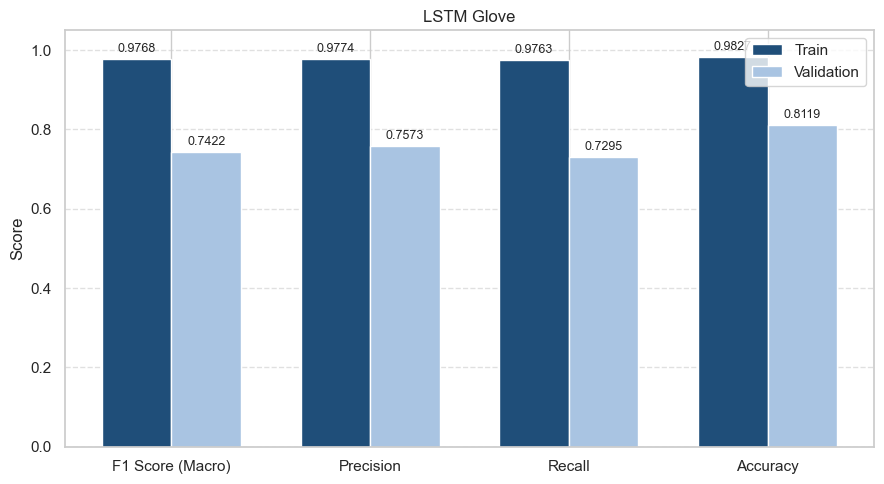

In [151]:
get_metrics_df(title, y_train, y_train_pred_glove, y_val, y_val_pred_glove)

# Plot metrics
plot_metrics(y_train, y_train_pred_glove, y_val, y_val_pred_glove, title=title)

## **2.4** RoBERTa

In [ ]:
# Tokenizer & Model
checkpoint = "cardiffnlp/twitter-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)

In [ ]:
# Oversample
train_texts_over, train_labels_over = oversample_data(train_texts, train_labels)

In [ ]:
# Tokenize and convert to Dataset
train_ds = Dataset.from_dict({"text": train_texts, "label": train_labels}).map(tokenize, batched=True)
val_ds = Dataset.from_dict({"text": val_texts, "label": val_labels}).map(tokenize, batched=True)
dataset = DatasetDict({"train": train_ds, "validation": val_ds})

In [ ]:
# Model init with weighted loss
def model_init():
    model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)
    class_weights = torch.tensor(
        np.bincount(train_labels, minlength=3) / len(train_labels),
        dtype=torch.float
    )
    class_weights = 1.0 / class_weights
    model.classifier.loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights)
    return model

In [ ]:
# Search space
def hp_space(trial: Trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True),
        "num_train_epochs": trial.suggest_int("num_train_epochs", 4, 10),
        "weight_decay": trial.suggest_float("weight_decay", 0.0, 0.3),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [8, 16, 32]),
        "warmup_ratio": trial.suggest_float("warmup_ratio", 0.0, 0.2)
    }

In [ ]:
# Training args
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    logging_dir="./logs",
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="loss",
    greater_is_better=False,
    report_to=[]
)

In [ ]:
# Trainer for tuning
trainer = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics_roberta
)

In [ ]:
# Hyperparameter tuning
best_trial = trainer.hyperparameter_search(
    direction="maximize",
    n_trials=15,
    hp_space=hp_space,
    backend="optuna"
)

In [ ]:
# Retrain with best trial
best_args = training_args.clone()
for k, v in best_trial.hyperparameters.items():
    setattr(best_args, k, v)

best_model = model_init()
best_trainer = Trainer(
    model=best_model,
    args=best_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics_roberta
)

best_trainer.train()


In [ ]:
# Get predictions for train and val sets
train_preds = best_trainer.predict(dataset["train"])
val_preds = best_trainer.predict(dataset["validation"])

train_labels = train_preds.label_ids
train_pred_labels = np.argmax(train_preds.predictions, axis=1)

val_labels = val_preds.label_ids
val_pred_labels = np.argmax(val_preds.predictions, axis=1)

In [ ]:
title = "Best RoBERTa Model Performance (Optuna)"

In [ ]:
metrics_df = get_metrics_df(title, train_labels, train_pred_labels, val_labels, val_pred_labels)
display(metrics_df)

plot_metrics(train_labels, train_pred_labels, val_labels, val_pred_labels, title=title)

In [ ]:
output_path = "./best_roberta_model"
best_model.save_pretrained(output_path)
tokenizer.save_pretrained(output_path)

<div class="alert alert-block alert-success">

# **3.** **Final Predictions**

<div>

In [ ]:
# Load the test dataset
test_data = pd.read_csv("../data/test.csv")
test_texts = test_data["text"].tolist()

# Get embeddings for test set
X_test_roberta = np.array(get_roberta_embeddings(train_texts, "X_test_roberta_embeddings.pkl", batch_size=32, force_reload=False))

In [ ]:
# Predict labels with the trained classifier
X_test_te3s_pred = clf_roberta_lr.predict(X_test_te3s)

# Create submission DataFrame
submission_te3s = pd.DataFrame({
    "id": test_data["id"],
    "label": X_test_roberta_pred
})

# Save submission to CSV
submission_te3s.to_csv("roberta_lr_pred_25.csv", index=False)
print("Submission file saved as roberta_lr_pred_25.csv")

In [ ]:
# Load the predictions from the saved CSV file
pred_25 = pd.read_csv("roberta_lr_pred_25.csv")
pred_25.head()